## Imports

In [149]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import yfinance as yf
import cplex

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cvxpy as cp

from datetime import datetime, timedelta
from math import sqrt

import os

%matplotlib inline

In [150]:
# model = "gpt-4o-2024-11-20" 
# model = "gpt-4.1"
# model = "o4-mini"
model = "gpt-5"
# model = "claude-3-7-sonnet-20250219"
# model = "claude-sonnet-4-20250514"
# model = "claude-opus-4-20250514"
# model = "deepseek-chat"
# model = "deepseek-reasoner"
# model = "gemini-2.5-pro-preview-05-06"
# model = "grok-3-latest"
# model = "grok-3-mini-latest"

avg_weights = True

Install CPLEX solver. To setup CPLEX solver for Python:
* Use the script `setup.py` located in the directory `yourCPLEXhome/python`
* Execute the following command from the command line `python yourCPLEXhome/python/setup.py install` or `python yourCPLEXhome/python/setup.py install --home yourPythonPackageshome`
* Set the environment variable `PYTHONPATH` to `yourCPLEXhome/python/VERSION/PLATFORM`

## Identify sector parameters

To process the sector, uncomment the cell. Comment cells with sectors that are not processed at the moment.

In [151]:
# sector_name = 'energy'
# sector_name_full = 'Energy'
# sector_ticker = '^GSPE'
# full_ticker = 'SP500-10'

In [152]:
# sector_name = 'materials'
# sector_name_full = 'Materials'
# sector_ticker = '^SP500-15'
# full_ticker = 'SP500-15'

In [153]:
# sector_name = 'industrials'
# sector_name_full = 'Industrials'
# sector_ticker = '^SP500-20'
# full_ticker = 'SP500-20'

In [154]:
# sector_name = 'consumer_discretionary'
# sector_name_full = 'Consumer Discretionary'
# sector_ticker = '^SP500-25'
# full_ticker = 'SP500-25'

In [155]:
# sector_name = 'consumer_staples'
# sector_name_full = 'Consumer Staples'
# sector_ticker = '^SP500-30'
# full_ticker = 'SP500-30'

In [156]:
# sector_name = 'health_care'
# sector_name_full = 'Health Care'
# sector_ticker = '^SP500-35'
# full_ticker = 'SP500-35'

In [157]:
# sector_name = 'financials'
# sector_name_full = 'Financials'
# sector_ticker = '^SP500-40'
# full_ticker = 'SP500-40'

In [158]:
# sector_name = 'information_technology'
# sector_name_full = 'Information Technology'
# sector_ticker = '^SP500-45'
# full_ticker = 'SP500-45'

In [159]:
# sector_name = 'communication_services'
# sector_name_full = 'Communication Services'
# sector_ticker = '^SP500-50'
# full_ticker = 'SP500-50'

In [160]:
sector_name = 'utilities'
sector_name_full = 'Utilities'
sector_ticker = '^SP500-55'
full_ticker = 'SP500-55'

In [161]:
# sector_name = 'real_estate'
# sector_name_full = 'Real Estate'
# sector_ticker = '^SP500-60'
# full_ticker = 'SP500-60'

## Process data

In [162]:
## In-sample end date (using 5 years of weekly data prior to end date)
insample_enddate = datetime(2024, 12, 31)

## Out-of-sample period (1 Jan 2025 to 31 Mar 2025) (using daily data))
outsample_startdate = datetime(2025, 1, 1)
outsample_enddate   = datetime(2025, 3,  31)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Jan 2025

In [163]:
sp500_df = pd.read_csv('SP500.csv')  
companies = sp500_df[sp500_df['GICS Sector'] == sector_name_full]['Symbol']
companies

12      AEE
13      AEP
14      AES
42      ATO
46      AWK
84      CEG
98      CMS
100     CNP
124       D
144     DTE
145     DUK
152      ED
155     EIX
167      ES
170     ETR
171    EVRG
173     EXC
184      FE
285     LNT
332     NEE
335      NI
339     NRG
363     PCG
364     PEG
378     PNW
382     PPL
413      SO
417     SRE
474     VST
484     WEC
496     XEL
Name: Symbol, dtype: object

## Load Data

In [164]:
# in-sample
sp500_ins = yf.download(sector_ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust = False)  ## add "auto_adjust = False"
sp500_ins['SP_Return'] = sp500_ins['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_ins.dropna(subset=[('SP_Return', '')], inplace=True) # removed first row with NaN in return
## change subset from ['SP_Return'] to [('SP_Return', '')] for MultiIndex

# out-of-sample
sp500_outs = yf.download(sector_ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust = False)  ## add auto_adjust = False
sp500_outs['SP_Return'] = sp500_outs['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_outs.dropna(subset=[('SP_Return', '')], inplace=True) # removed first row with NaN in return
## change subset from ['SP_Return'] to [('SP_Return', '')] for MultiIndex

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [165]:
insample_data_filename = f'4_returns_insample/SP500_{sector_name}_returns_till_Jan2025.csv'
outsample_data_filename = f'4_returns_outsample/SP500_{sector_name}_returns_since_Jan2025.csv'

In [166]:
if os.path.isfile(insample_data_filename):
    print("Reading data from file", insample_data_filename)
    df_returns = pd.read_csv(insample_data_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    returns = {}

    for ticker in companies:
        ticker_saved = ticker
        if '.' in ticker: ticker = ticker.replace('.', '-')
        
        try:
            df_temp = yf.download(ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust = False)

            df_temp['Return'] = df_temp['Adj Close'].pct_change()

            # removing first row because first return will be Nan
            df_temp = df_temp.iloc[1:]

            df_temp = df_temp[df_temp.index.isin(sp500_ins.index)]

            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            returns[ticker_saved] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    df_returns = pd.DataFrame(returns)
    df_returns.to_csv(insample_data_filename)

Reading data from file 4_returns_insample/SP500_utilities_returns_till_Jan2025.csv


In [167]:
if os.path.isfile(outsample_data_filename):
    print("Reading data from file", outsample_data_filename)
    df_returnsOUT = pd.read_csv(outsample_data_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    returnsOS = {}

    for ticker in companies:
        ticker_saved = ticker
        if '.' in ticker: ticker = ticker.replace('.', '-')
        
        try:
            df_temp = yf.download(ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust = False)

            df_temp['Return'] = df_temp['Adj Close'].pct_change()
            
            # removing first row because first return will be NaN
            df_temp = df_temp.iloc[1:]            

            df_temp = df_temp[df_temp.index.isin(sp500_outs.index)]

            # If not all dates in S&P 500 data are present in stock data, skip this stock
            if not sp500_outs.index.isin(df_temp.index).all():
                print(f'Skipping {ticker} due to mismatch in trading dates.')
                continue

            # If there are still NaN values in stock returns, skip this stock
            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            returnsOS[ticker_saved] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    df_returnsOUT = pd.DataFrame(returnsOS)
    df_returnsOUT.to_csv(outsample_data_filename)

Reading data from file 4_returns_outsample/SP500_utilities_returns_since_Jan2025.csv


-----

In [168]:
index_tickers = ["^GSPC", "^IXIC", sector_ticker]

index_data_outs = pd.DataFrame()

# Download historical data for each index for out-of-sample period
yf_enddate = outsample_enddate + timedelta(days=1)
for ticker in index_tickers:
    index_df = yf.download(ticker, start=outsample_startdate, end=yf_enddate, interval='1d', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_outs[ticker] = index_df['Index_Return']

index_data_outs.index = pd.to_datetime(index_data_outs.index)

valid_index_tickers_outs = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in out-of-sample period
    if ticker in index_data_outs.columns and index_data_outs[ticker].notna().all():
        valid_index_tickers_outs.append(ticker)


index_tickers = valid_index_tickers_outs

print("Valid Index Tickers in Out-of-Sample Period")
print(valid_index_tickers_outs)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in Out-of-Sample Period
['^GSPC', '^IXIC', '^SP500-55']


In [169]:
index_tickers = ["^GSPC", "^IXIC", sector_ticker]

index_data_ins = pd.DataFrame()

# Download historical data for each index for in-sample period
for ticker in index_tickers:
    index_df = yf.download(ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_ins[ticker] = index_df['Index_Return']

index_data_ins.index = pd.to_datetime(index_data_ins.index)

valid_index_tickers_ins = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in in-sample period
    if ticker in index_data_ins.columns and index_data_ins[ticker].notna().all():
        valid_index_tickers_ins.append(ticker)


# index_tickers = valid_index_tickers_ins

print("Valid Index Tickers in In-Sample Period")
print(valid_index_tickers_ins)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in In-Sample Period
['^GSPC', '^IXIC', '^SP500-55']


In [170]:
## In-sample end date (using 10 years of weekly data prior to end date)
insample_enddate = datetime(2024, 12, 31)

## Out-of-sample period (1 Jan 2025 to 31 Mar 2025) (using daily data))
outsample_startdate = datetime(2025, 1, 1)
outsample_enddate   = datetime(2025, 3, 31)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Jan 2025

In [171]:
# in-sample
sp500_ins = yf.download(sector_ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust=False) 
sp500_ins['SP_Return'] = sp500_ins['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_ins.dropna(subset=[('SP_Return','')], inplace=True) # 1256 X 7 (removed first row with NaN in return)

# out-of-sample
sp500_outs = yf.download(sector_ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust=False) 
sp500_outs['SP_Return'] = sp500_outs['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_outs.dropna(subset=[('SP_Return','')], inplace=True) # removed first row with NaN in return 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [172]:
insample_data_filename = f'4_returns_insample/SP500_{sector_name}_returns_till_Jan2025.csv'
outsample_data_filename = f'4_returns_outsample/SP500_{sector_name}_returns_since_Jan2025.csv'

In [173]:
print("Reading data from file", insample_data_filename)
df_returns = pd.read_csv(insample_data_filename, index_col=0)

print("Reading data from file", outsample_data_filename)
df_returnsOUT = pd.read_csv(outsample_data_filename, index_col=0)

Reading data from file 4_returns_insample/SP500_utilities_returns_till_Jan2025.csv
Reading data from file 4_returns_outsample/SP500_utilities_returns_since_Jan2025.csv


In [174]:
# df_returnsOUT.index = pd.to_datetime(df_returnsOUT.index)
# df_returnsOUT = df_returnsOUT.loc[outsample_startdate:outsample_enddate]

## Mean Cumulative Out-of-sample Return and Volatility for each sector

In [175]:
temp_index_data_outs = index_data_outs.copy()
outsample_data = pd.DataFrame(index=temp_index_data_outs.index)
outsample_data[sector_name_full] = (1 + temp_index_data_outs[ticker]).cumprod()
outsample_data.index = pd.to_datetime(outsample_data.index)
outsample_data
print(f"mean cum. return of outdata: {outsample_data.mean()}")
print(f"volatility: {outsample_data.std()} ")

mean cum. return of outdata: Utilities    1.022453
dtype: float64
volatility: Utilities    0.016574
dtype: float64 


In [176]:
sectors = ['energy', 'materials', 'industrials', 'consumer_discretionary',\
           'consumer_staples', 'health_care', 'financials', 'information_technology',\
           'communication_services', 'utilities', 'real_estate']

In [177]:
csv_path = 'cached/sector_performance/sector_performance_summary_Jan2025.csv'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
else:
    df = pd.DataFrame(index = sectors, columns=['mean_cum_return', 'volatility'])

mean_ret = outsample_data[sector_name_full].mean()
volatility = outsample_data[sector_name_full].std()

df.loc[sector_name, 'mean_cum_return'] = mean_ret
df.loc[sector_name, 'volatility'] = volatility

df.to_csv(csv_path)

In [178]:
df

,mean_cum_return,volatility
energy,1.037267,0.025880
materials,1.050402,0.022850
industrials,1.028976,0.024354
consumer_discretionary,0.973021,0.070055
consumer_staples,1.032195,0.030013
health_care,1.055187,0.020274
financials,1.039232,0.029072
information_technology,0.961992,0.047991
communication_services,1.015604,0.045977
utilities,1.022453,0.016574


## Processing

In [179]:
def process_sector_data(df_sector):
    stocks = list(df_sector['Stock'].str.replace(" ", "").values)
    eq_weights = [1/len(stocks)] * len(stocks)
    llm_weights = list(df_sector['Weight'].values.astype(float))

    return stocks, eq_weights, llm_weights

In [180]:
# not avg_weights
#gpt
if model == 'gpt-4o-2024-11-20' and not avg_weights:
    csv_filename = f'cached/gpt/4o_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'gpt-4.1' and not avg_weights:
    csv_filename = f'cached/gpt/4.1_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'o4-mini' and not avg_weights:
    csv_filename = f'cached/gpt/o4-mini_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'gpt-5' and not avg_weights:
    csv_filename = f'cached/gpt/5_weights_assigned/responses20_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat' and not avg_weights:
    csv_filename = f'cached/ds/dsV3_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner' and not avg_weights:
    csv_filename = f'cached/ds/dsR1_weights_assigned/responses20_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219' and not avg_weights:
    csv_filename = f'cached/claude/sonnet-3.7_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514' and not avg_weights:
    csv_filename = f'cached/claude/sonnet-4_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514' and not avg_weights:
    csv_filename = f'cached/claude/opus-4_weights_assigned/responses20_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and not avg_weights:
    csv_filename = f'cached/gemini/gemini_weights_assigned/responses20_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest' and not avg_weights:
    csv_filename = f'cached/grok/grok3_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest' and not avg_weights:
    csv_filename = f'cached/grok/grok3-mini_weights_assigned/responses20_auto_{sector_name}.csv'

# average weights
# gpt
elif model == 'gpt-4o-2024-11-20' and avg_weights:
    csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'gpt-4.1' and avg_weights:
    csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'o4-mini' and avg_weights:
    csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == "gpt-5" and avg_weights:
    csv_filename = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat' and avg_weights:
    csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner' and avg_weights:
    csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
    csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514' and avg_weights:
    csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514' and avg_weights:
    csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
    csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest' and avg_weights:
    csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest' and avg_weights:
    csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'

In [181]:
model_name_mapping = {
    "gpt-4o-2024-11-20": "gpt4o",
    "gpt-4.1": "gpt4.1", 
    "o4-mini": "o4-mini",
    "gpt-5": "gpt5",
    "claude-3-7-sonnet-20250219": "sonnet-3.7",
    "claude-sonnet-4-20250514": "sonnet-4",
    "claude-opus-4-20250514": "opus-4",
    "deepseek-chat": "dsV3",
    "deepseek-reasoner": "dsR1",
    "gemini-2.5-pro-preview-05-06": "gemini",
    "grok-3-latest": "grok3",
    "grok-3-mini-latest": "grok3-mini"
}

In [182]:
model_short = model_name_mapping[model]

In [183]:
df_sector = pd.read_csv(csv_filename)

stocks, eq_weights, llm_weights = process_sector_data(df_sector)

# Assign variables dynamically
globals()[f'{model_short}_df_{sector_name}'] = df_sector
globals()[f'{model_short}_stocks_{sector_name}'] = stocks
globals()[f'{model_short}_eq_weights_{sector_name}'] = eq_weights
globals()[f'{model_short}_weights_llm_{sector_name}'] = llm_weights

In [184]:
globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [185]:
tickers_sp500out = np.array(df_returnsOUT.columns)

## Efficient frontiers

In [186]:
def frontiers(returns_df, asset_list, num_portf, lb, ub, risk_free_rate, model_name):
    # Calculate the covariance matrix and expected returns and scaling them to ANNUAL
    # ts_freq = np.diff(returns_df.index).min()
    try:
        ts_freq = pd.infer_freq(returns_df.index)[0]

        scalef = 252
        if ts_freq=='W':
            scalef = 52
        elif ts_freq=='M':
            scalef = 12
    except TypeError:        
        scalef = 52
        
    Q = returns_df[asset_list].cov() * scalef  # 52 weeks in a year
    mu_pd = returns_df[asset_list].mean() * scalef
    mu = mu_pd.values
    
    ## Minimum variance portfolio
    w = cp.Variable(len(asset_list))
    prob1 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                      [sum(w) == 1,
                       w >= 0])
    prob1.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_minVar = w.value
    # var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
    ret_minVar = np.dot(mu, w_minVar)
    
    ## Max return portfolio
    w = cp.Variable(len(asset_list))
    prob2 = cp.Problem(cp.Maximize(mu.T@w),
                    [sum(w) == 1,
                     w >= 0])
    prob2.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_maxRet = w.value
    # var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet))
    ret_maxRet = np.dot(mu, w_maxRet)
    
    ## Efficient Frontier
    targetRet = np.linspace(ret_minVar, ret_maxRet, num_portf)
    w = cp.Variable(len(asset_list))
    eps = cp.Parameter()
    eps.value = targetRet[0]
    prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                    [mu.T@w >= eps,
                     sum(w) == 1,
                     w >= 0])
    # Compute efficient frontier
    w_front = []
    var_front = []
    ret_front = []
    sharpe_ratio_front = []
    
    for epsilon in targetRet:
        eps.value = epsilon
        prob3.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
        w_front.append(w.value)
        var_front.append(np.dot(w.value, np.dot(Q, w.value)))
        ret_front.append(np.dot(mu, w.value))
        sharpe_ratio = (np.dot(mu, w.value) - risk_free_rate) / np.sqrt(np.dot(w.value, np.dot(Q, w.value)))
        sharpe_ratio_front.append(sharpe_ratio)
    
    # Find the portfolio with the maximum Sharpe ratio
    max_sharpe_ratio_index = np.argmax(sharpe_ratio_front)
    # weights_max_sharpe = w_front[max_sharpe_ratio_index]
    ret_max_sharpe = ret_front[max_sharpe_ratio_index]
    var_max_sharpe = var_front[max_sharpe_ratio_index]
        
    ## Minimum variance portfolio with bounds
    w = cp.Variable(len(asset_list))
    prob5 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                    [cp.sum(w) == 1,
                     w >= lb,
                     w <= ub])
    prob5.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_minVar_bounded = w.value
    # var_minVar_bounded = np.dot(w_minVar_bounded, np.dot(Q, w_minVar_bounded))
    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_Jan2025_minvar_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in w_minVar_bounded]))

    ret_minVar_bounded = np.dot(mu, w_minVar_bounded)
    
    ## Max return portfolio with bounds
    w = cp.Variable(len(asset_list))
    prob6 = cp.Problem(cp.Maximize(mu.T@w),
                        [cp.sum(w) == 1,
                         w >= lb,
                         w <= ub])
    prob6.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_maxRet_bounded = w.value
    # var_maxRet_bounded = np.dot(w_maxRet_bounded, np.dot(Q, w_maxRet_bounded))
    ret_maxRet_bounded = np.dot(mu, w_maxRet_bounded)

    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_Jan2025_maxret_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in w_maxRet_bounded]))
    # ret_maxRet_bounded = np.dot(mu, w_maxRet_bounded)    

    ## Efficient Frontier with bounds
    targetRetB = np.linspace(ret_minVar_bounded, ret_maxRet_bounded, num_portf)
    w = cp.Variable(len(asset_list))
    eps = cp.Parameter()
    eps.value = targetRetB[0]
    prob7 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                        [mu.T @ w >= eps,
                         cp.sum(w) == 1,
                         w >= lb,
                         w <= ub])
    w_front_bounded = []
    var_front_bounded = []
    ret_front_bounded = []
    sharpe_ratio_front_bounded = []
    
    for epsilon in targetRetB:
        eps.value = epsilon
        prob7.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
        w_front_bounded.append(w.value)
        var_front_bounded.append(np.dot(w.value, np.dot(Q, w.value)))

        ret_front_bounded.append(np.dot(mu, w.value))
        
        sharpe_ratio = (np.dot(mu, w.value) - risk_free_rate) / np.sqrt(np.dot(w.value, np.dot(Q, w.value)))
        sharpe_ratio_front_bounded.append(sharpe_ratio)
        
    # Find the portfolio with the maximum Sharpe ratio
    max_sharpe_ratio_bounded_index = np.argmax(sharpe_ratio_front_bounded)
    weights_max_sharpe_bounded = w_front_bounded[max_sharpe_ratio_bounded_index]
    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_Jan2025_maxsharpe_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in weights_max_sharpe_bounded]))
    ret_max_sharpe_bounded = ret_front_bounded[max_sharpe_ratio_bounded_index]
    var_max_sharpe_bounded = var_front_bounded[max_sharpe_ratio_bounded_index]

    return (ret_front, var_front, ret_max_sharpe, var_max_sharpe, \
            ret_front_bounded, var_front_bounded, ret_max_sharpe_bounded, \
                var_max_sharpe_bounded, w_minVar_bounded, w_maxRet_bounded, weights_max_sharpe_bounded)

In [187]:
lbA = 0.03
ubA = 0.13

In [188]:
df_returns = pd.read_csv(f'4_returns_insample/SP500_{sector_name}_returns_till_Jan2025.csv')
try:
    df_returns['Date'] = pd.to_datetime(df_returns['Date'], format='%Y-%m-%d %H:%M:%S')
except ValueError:
    df_returns['Date'] = pd.to_datetime(df_returns['Date'] + ' 00:00:00', format='%Y-%m-%d %H:%M:%S')

df_returns = df_returns.set_index('Date')

In [189]:
# ret_front20, var_front20, ret_max_sharpe20, var_max_sharpe20, ret_front_bounded20, \
#     var_front_bounded20, ret_max_sharpe_bounded20, var_max_sharpe_bounded20, w_min_var_bounded20, \
#     w_max_ret_bounded20, w_max_sharpe_bounded20 = frontiers(df_returns, globals()[f'stocks_{sector_name}'], 200, lbA, ubA, 0.01, model)

In [190]:
ret_front20, var_front20, ret_max_sharpe20, var_max_sharpe20, ret_front_bounded20, \
    var_front_bounded20, ret_max_sharpe_bounded20, var_max_sharpe_bounded20, w_min_var_bounded20, \
    w_max_ret_bounded20, w_max_sharpe_bounded20 = frontiers(df_returns, globals()[f'{model_short}_stocks_{sector_name}'], 200, lbA, ubA, 0.01, model_short)

globals()[f'{model_short}_ret_front20_{sector_name}'] = ret_front20
globals()[f'{model_short}_var_front20_{sector_name}'] = var_front20
globals()[f'{model_short}_ret_max_sharpe20_{sector_name}'] = ret_max_sharpe20
globals()[f'{model_short}_var_max_sharpe20_{sector_name}'] = var_max_sharpe20
globals()[f'{model_short}_ret_front_bounded20_{sector_name}'] = ret_front_bounded20
globals()[f'{model_short}_var_front_bounded20_{sector_name}'] = var_front_bounded20
globals()[f'{model_short}_ret_max_sharpe_bounded20_{sector_name}'] = ret_max_sharpe_bounded20
globals()[f'{model_short}_var_max_sharpe_bounded20_{sector_name}'] = var_max_sharpe_bounded20
globals()[f'{model_short}_w_min_var_bounded20_{sector_name}'] = w_min_var_bounded20
globals()[f'{model_short}_w_max_ret_bounded20_{sector_name}'] = w_max_ret_bounded20
globals()[f'{model_short}_w_max_sharpe_bounded20_{sector_name}'] = w_max_sharpe_bounded20

## Plot frontiers

In [191]:
def plot_frontiers(returns_df, params_llm, sector, model):
    asset_list, weights_eq, weights_llm, ret_front, var_front, ret_max_sharpe, \
        var_max_sharpe, ret_front_bounded, var_front_bounded, ret_max_sharpe_bounded, \
            var_max_sharpe_bounded = params_llm
    
    # Calculate the covariance matrix and expected returns and scaling them to ANNUAL
    try:
        ts_freq = pd.infer_freq(returns_df.index)[0]
        ##print(ts_freq) ##

        scalef = 252
        if ts_freq=='W':
            scalef = 52
        elif ts_freq=='M':
            scalef = 12
    except TypeError:        
        scalef = 252 ##
    ##print (scalef)##

    Q = returns_df[asset_list].cov() * scalef  # 52 weeks in a year
    mu_pd = returns_df[asset_list].mean() * scalef
    mu = mu_pd.values
     
    # Compute expected returns, variances, and standard deviations for LLM weighted portfolio
    ret_llm = np.dot(mu, weights_llm)
    var_llm = np.dot(weights_llm, np.dot(Q, weights_llm))
    std_llm = np.sqrt(var_llm)

    # Compute expected returns, variances, and standard deviations for equally weighted portfolio
    ret_eq = np.dot(mu, weights_eq)
    var_eq = np.dot(weights_eq, np.dot(Q, weights_eq))
    std_eq = np.sqrt(var_eq)

    fig = plt.figure(figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
    ax = plt.gca()
    plt.rcParams['figure.figsize'] = [10, 5]

    ax.scatter(x=np.sqrt(var_front[0]), y=ret_front[0], marker='D', s=50, color='DarkGreen', label='minimum variance portfolio')
    ax.scatter(x=np.sqrt(var_front[-1]), y=ret_front[-1], marker='s', s=50, color='DarkMagenta', label='maximum return portfolio')
    ax.scatter(x=np.sqrt(var_front_bounded[0]), y=ret_front_bounded[0], marker='D', s=50, color='pink', label='minimum variance portfolio bounded')
    ax.scatter(x=np.sqrt(var_front_bounded[-1]), y=ret_front_bounded[-1], marker='s', s=50, color='brown', label='maximum return portfolio bounded')

    ax.plot(np.sqrt(var_front), ret_front, 'k--', label='efficient frontier')

    # Plot efficient frontier for bounded case
    ax.plot(np.sqrt(var_front_bounded), ret_front_bounded, 'k-', label='efficient frontier bounded')

    # Plot volatility versus expected return for individual stocks
    ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, color='lightgrey', label='individual stocks')

    ax.scatter(x=std_llm, y=ret_llm, marker='o', s=50, color='red', label='LLM weighted LLM portfolio')

    ax.scatter(x=std_eq, y=ret_eq, marker='o', s=50, color='yellow', label='Equally weighted LLM portfolio')

    ax.scatter(x=np.sqrt(var_max_sharpe), y=ret_max_sharpe, marker='o', s=50, color='green', label='Maximum Sharpe portfolio')

    ax.scatter(x=np.sqrt(var_max_sharpe_bounded), y=ret_max_sharpe_bounded, marker='o', s=50, color='cyan', label='Maximum Sharpe portfolio bounded')

    # Format and display the final plot
    ax.axis([0.9 * np.sqrt(var_front[0]), 1.2 * np.max(np.sqrt(np.diag(Q))), np.min(mu) - 0.1 * (np.max(mu) - np.min(mu)), 1.1 * ret_front[-1]])
    ax.set_xlabel('Volatility (Standard Deviation)')
    ax.set_ylabel('Expected Return (annualized)')
    plt.title(f'Efficient frontier for {str(len(asset_list))} stocks selected by {model} for {sector}')
    ax.legend(loc="lower right", fontsize='small')  # Adjust font size here
    ax.grid()
    plt.show()

In [192]:
# params_llm = [globals()[f'stocks_{sector_name}'], globals()[f'eq_weights_{sector_name}'], globals()[f'weights_llm_{sector_name}'], \
#                ret_front20, var_front20, ret_max_sharpe20, var_max_sharpe20, ret_front_bounded20, var_front_bounded20, ret_max_sharpe_bounded20,\
#                   var_max_sharpe_bounded20]


In [193]:
params_llm = [globals()[f'{model_short}_stocks_{sector_name}'], globals()[f'{model_short}_eq_weights_{sector_name}'], globals()[f'{model_short}_weights_llm_{sector_name}'], \
               globals()[f'{model_short}_ret_front20_{sector_name}'], globals()[f'{model_short}_var_front20_{sector_name}'], globals()[f'{model_short}_ret_max_sharpe20_{sector_name}'], globals()[f'{model_short}_var_max_sharpe20_{sector_name}'], \
               globals()[f'{model_short}_ret_front_bounded20_{sector_name}'], globals()[f'{model_short}_var_front_bounded20_{sector_name}'], globals()[f'{model_short}_ret_max_sharpe_bounded20_{sector_name}'], \
               globals()[f'{model_short}_var_max_sharpe_bounded20_{sector_name}']]


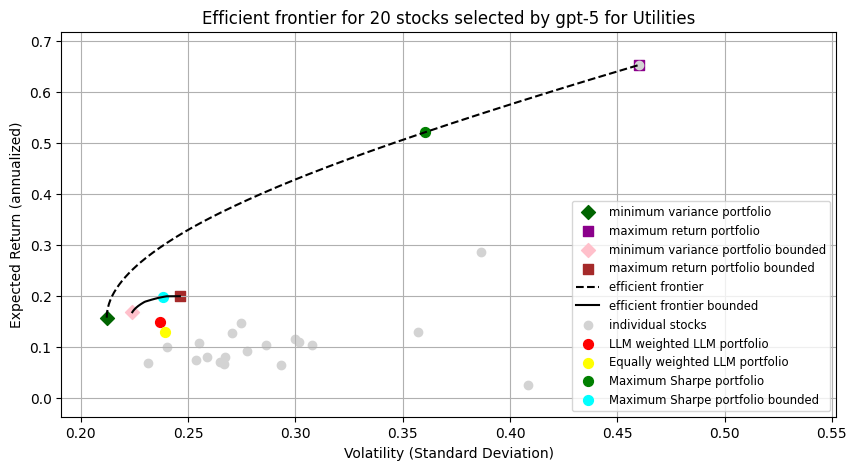

In [194]:
## I think this is for in-sample data?
plot_frontiers(df_returns, params_llm, sector_name_full, model)

## Plot portfolio performance

In [195]:
# Weights of all portfolios
weights = {
    f"LLM_weighted_{sector_name}": globals()[f'{model_short}_weights_llm_{sector_name}'],
    f"LLM_equal_{sector_name}": globals()[f'{model_short}_eq_weights_{sector_name}'],
    "LLM Min Var": globals()[f'{model_short}_w_min_var_bounded20_{sector_name}'],
    "LLM Max Ret": globals()[f'{model_short}_w_max_ret_bounded20_{sector_name}'],
    "LLM Max Sharpe": globals()[f'{model_short}_w_max_sharpe_bounded20_{sector_name}']
}

In [196]:
temp_stock_return = globals()[f'{model_short}_stock_returns_{sector_name}']
temp_stock_return.index = pd.to_datetime(temp_stock_return.index)
first_date = temp_stock_return.index[0]
previous_trading_date = first_date - BDay(1)
full_index = [previous_trading_date] + list(temp_stock_return.index)
cumulative_returns_llm = pd.DataFrame(index=full_index)  ## create df only with index - date

In [197]:
i = 0
for name, weight in weights.items():
    temp_stock_return = globals()[f'{model_short}_stock_returns_{sector_name}']
    first_date = temp_stock_return.index[0]
    temp_stock_return.index = pd.to_datetime(temp_stock_return.index)
    previous_trading_date = first_date - BDay(1)
    baseline_row = pd.DataFrame(
        data=np.zeros((1, temp_stock_return.shape[1])),  
        index=[previous_trading_date],                    
        columns=temp_stock_return.columns               
    )
    temp_stock_return_with_baseline = pd.concat([baseline_row, temp_stock_return])
    portfolio_return = (temp_stock_return_with_baseline * weight).sum(axis=1)
    cumulative_returns_llm[name] = (1 + portfolio_return).cumprod()
    i+=1

In [198]:
cumulative_returns_llm

,LLM_weighted_utilities,LLM_equal_utilities,LLM Min Var,LLM Max Ret,LLM Max Sharpe
2025-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
2025-01-03,1.009780,1.009013,1.009790,1.017474,1.017333
2025-01-06,0.999847,0.997046,1.003184,1.012704,1.012784
2025-01-07,0.995921,0.994684,0.998914,1.004979,1.005770
2025-01-08,0.999217,0.999928,1.001867,1.006227,1.008295
2025-01-10,1.000762,0.995129,1.016883,1.028308,1.028467
2025-01-13,0.992614,0.990444,1.007039,1.015665,1.015215
2025-01-14,1.005071,1.002186,1.021220,1.031049,1.030847
2025-01-15,1.020891,1.016003,1.036489,1.049746,1.049820
2025-01-16,1.047609,1.041650,1.064307,1.078395,1.077855


In [199]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_llm[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_llm.index = pd.to_datetime(cumulative_returns_llm.index)
outsample_data = cumulative_returns_llm.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()


for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))
    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))


num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of {num_asset} Asset Portfolios ({model}, equal weight) and {full_ticker} ({sector_name_full}) from Jan 25 to Mar 25',
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified"
)

fig.show()

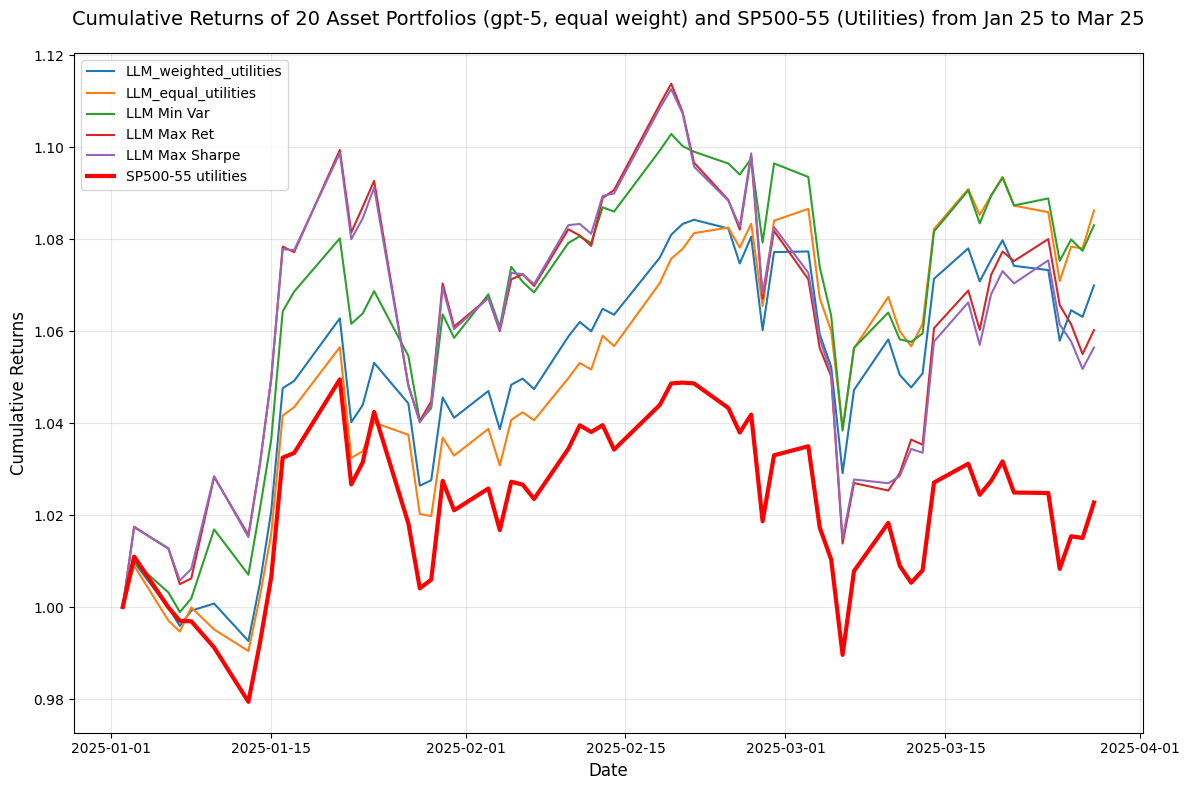

In [200]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_llm[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_llm.index = pd.to_datetime(cumulative_returns_llm.index)
outsample_data = cumulative_returns_llm.loc[outsample_startdate:outsample_enddate]

fig, ax = plt.subplots(figsize=(12, 8))

for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        ax.plot(outsample_data.index, 
                outsample_data[column], 
                linewidth=3, 
                color='red', 
                label=column)
    else:
        ax.plot(outsample_data.index, 
                outsample_data[column], 
                label=column)

num_asset = len(df_sector)
ax.set_title(f'Cumulative Returns of {num_asset} Asset Portfolios ({model}, equal weight) and {full_ticker} ({sector_name_full}) from Jan 25 to Mar 25', 
             fontsize=14, pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Returns', fontsize=12)


ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
# fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Comparing LLM Models: OpenAI, Anthropic, DeepSeek, Google, and X.AI

In [201]:
for model, model_short in model_name_mapping.items():
    if model == 'gpt-4o-2024-11-20' and avg_weights:
        csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'gpt-4.1' and avg_weights:
        csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'o4-mini' and avg_weights:
        csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'gpt-5' and avg_weights:
        csv_filename = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    # ds
    elif model == 'deepseek-chat' and avg_weights:
        csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner' and avg_weights:
        csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    # claude
    elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
        csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'claude-sonnet-4-20250514' and avg_weights:
        csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'claude-opus-4-20250514' and avg_weights:
        csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    # gemini
    elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
        csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    # grok
    elif model == 'grok-3-latest' and avg_weights:
        csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest' and avg_weights:
        csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    
    df_sector = pd.read_csv(csv_filename)

    stocks, eq_weights, llm_weights = process_sector_data(df_sector)

    # Assign variables dynamically
    globals()[f'{model_short}_df_{sector_name}'] = df_sector
    globals()[f'{model_short}_stocks_{sector_name}'] = stocks
    globals()[f'{model_short}_eq_weights_{sector_name}'] = eq_weights
    globals()[f'{model_short}_weights_llm_{sector_name}'] = llm_weights

In [202]:
for model, model_short in model_name_mapping.items():
    globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [203]:
for model, model_short in model_name_mapping.items():
    ret_front20, var_front20, ret_max_sharpe20, var_max_sharpe20, ret_front_bounded20, \
        var_front_bounded20, ret_max_sharpe_bounded20, var_max_sharpe_bounded20, w_min_var_bounded20, \
        w_max_ret_bounded20, w_max_sharpe_bounded20 = frontiers(df_returns, globals()[f'{model_short}_stocks_{sector_name}'], 200, lbA, ubA, 0.01, model_short)

    globals()[f'{model_short}_ret_front20_{sector_name}'] = ret_front20
    globals()[f'{model_short}_var_front20_{sector_name}'] = var_front20
    globals()[f'{model_short}_ret_max_sharpe20_{sector_name}'] = ret_max_sharpe20
    globals()[f'{model_short}_var_max_sharpe20_{sector_name}'] = var_max_sharpe20
    globals()[f'{model_short}_ret_front_bounded20_{sector_name}'] = ret_front_bounded20
    globals()[f'{model_short}_var_front_bounded20_{sector_name}'] = var_front_bounded20
    globals()[f'{model_short}_ret_max_sharpe_bounded20_{sector_name}'] = ret_max_sharpe_bounded20
    globals()[f'{model_short}_var_max_sharpe_bounded20_{sector_name}'] = var_max_sharpe_bounded20
    globals()[f'{model_short}_w_min_var_bounded20_{sector_name}'] = w_min_var_bounded20
    globals()[f'{model_short}_w_max_ret_bounded20_{sector_name}'] = w_max_ret_bounded20
    globals()[f'{model_short}_w_max_sharpe_bounded20_{sector_name}'] = w_max_sharpe_bounded20

In [204]:
temp_stock_return_compare = globals()[f'{model_short}_stock_returns_{sector_name}']
temp_stock_return_compare.index = pd.to_datetime(temp_stock_return_compare.index)
first_date_compare = temp_stock_return_compare.index[0]
previous_trading_date_compare = first_date_compare - BDay(1)
full_index_compare = [previous_trading_date_compare] + list(temp_stock_return_compare.index)

cumulative_returns_compare = pd.DataFrame(index=full_index_compare)

In [205]:
globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [206]:
for model_name, model_short in model_name_mapping.items():
    dict_name = f"weights_{model_short}"

    weights_dict = {
        f"{model_short}_weighted_{sector_name}": globals()[f'{model_short}_weights_llm_{sector_name}'],
        f"{model_short}_equal_{sector_name}": globals()[f'{model_short}_eq_weights_{sector_name}'],
        f"{model_short} Min Var": globals()[f'{model_short}_w_min_var_bounded20_{sector_name}'],
        f"{model_short} Max Ret": globals()[f'{model_short}_w_max_ret_bounded20_{sector_name}'],
        f"{model_short} Max Sharpe": globals()[f'{model_short}_w_max_sharpe_bounded20_{sector_name}']
    }
    
    globals()[dict_name] = weights_dict

In [207]:
model_shorts = ["gpt4o", "gpt4.1", "o4-mini", "gpt5", "sonnet-3.7", "sonnet-4", "opus-4", 
                "dsV3", "dsR1", "gemini", "grok3", "grok3-mini"]

for model_short in model_shorts:
    weights_dict = globals()[f'weights_{model_short}']
    
    temp_stock_return_compare = globals()[f'{model_short}_stock_returns_{sector_name}']

    for name, weight in weights_dict.items():
        temp_stock_return_compare.index = pd.to_datetime(temp_stock_return_compare.index)
        first_date_compare = temp_stock_return_compare.index[0]
        previous_trading_date_compare = first_date_compare - BDay(1)
        baseline_row1 = pd.DataFrame(
            data=np.zeros((1, temp_stock_return_compare.shape[1])),  
            index=[previous_trading_date_compare],                    
            columns=temp_stock_return_compare.columns               
        )
        temp_stock_return_compare_with_baseline = pd.concat([baseline_row1, temp_stock_return_compare])

        portfolio_return_compare = (temp_stock_return_compare_with_baseline * weight).sum(axis=1)
        cumulative_returns_compare[name] = (1 + portfolio_return_compare).cumprod()

print(cumulative_returns_compare.columns)

Index(['gpt4o_weighted_utilities', 'gpt4o_equal_utilities', 'gpt4o Min Var',
       'gpt4o Max Ret', 'gpt4o Max Sharpe', 'gpt4.1_weighted_utilities',
       'gpt4.1_equal_utilities', 'gpt4.1 Min Var', 'gpt4.1 Max Ret',
       'gpt4.1 Max Sharpe', 'o4-mini_weighted_utilities',
       'o4-mini_equal_utilities', 'o4-mini Min Var', 'o4-mini Max Ret',
       'o4-mini Max Sharpe', 'gpt5_weighted_utilities', 'gpt5_equal_utilities',
       'gpt5 Min Var', 'gpt5 Max Ret', 'gpt5 Max Sharpe',
       'sonnet-3.7_weighted_utilities', 'sonnet-3.7_equal_utilities',
       'sonnet-3.7 Min Var', 'sonnet-3.7 Max Ret', 'sonnet-3.7 Max Sharpe',
       'sonnet-4_weighted_utilities', 'sonnet-4_equal_utilities',
       'sonnet-4 Min Var', 'sonnet-4 Max Ret', 'sonnet-4 Max Sharpe',
       'opus-4_weighted_utilities', 'opus-4_equal_utilities', 'opus-4 Min Var',
       'opus-4 Max Ret', 'opus-4 Max Sharpe', 'dsV3_weighted_utilities',
       'dsV3_equal_utilities', 'dsV3 Min Var', 'dsV3 Max Ret',
       'dsV3 Ma

In [208]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)

In [209]:
cumrets_mean = cumulative_returns_compare.mean().tolist()[:-1]
cumrets_mean = [str(x) for x in cumrets_mean]
with open('metrics/cumulative_returns_all.csv', 'a', encoding='utf-8') as f:
    content = ','.join(cumrets_mean)
    print((f'{sector_name},{content}\n'))
    f.write(f'{sector_name},{content}\n')

utilities,1.0384629498051072,1.039254264766332,1.0421856633306108,1.0409194369927104,1.0401398375453477,1.0418877588647002,1.0458259602319593,1.045557102023536,1.0448939204362075,1.0441153581647347,1.045568837724413,1.0470669197107096,1.0491272790839434,1.0283001388144117,1.044637332704054,1.050796777639262,1.051617157876209,1.0657331141376871,1.0616274623934454,1.0609925076160904,1.0528275250141126,1.0602104495662603,1.070144354524823,1.0742189763876493,1.0702794322872422,1.0509721073701366,1.0536064966018903,1.0648179815841698,1.0563155520440763,1.0557125651287602,1.0461964663260177,1.0517610605508256,1.0644798617220845,1.0548376914107829,1.0548376914107827,1.0360769910126217,1.0282070979918747,1.0351899187707707,1.0375093111679683,1.0329807628704986,1.0398721496286996,1.0464105869184603,1.0443727692551612,1.0451995404671433,1.044355485090554,1.044541158781113,1.0476641038583634,1.053574560409661,1.055028136374086,1.0548681128850557,1.0468058344468818,1.0466236186911315,1.04629798777

In [210]:
print(cumulative_returns_compare.columns)

Index(['gpt4o_weighted_utilities', 'gpt4o_equal_utilities', 'gpt4o Min Var',
       'gpt4o Max Ret', 'gpt4o Max Sharpe', 'gpt4.1_weighted_utilities',
       'gpt4.1_equal_utilities', 'gpt4.1 Min Var', 'gpt4.1 Max Ret',
       'gpt4.1 Max Sharpe', 'o4-mini_weighted_utilities',
       'o4-mini_equal_utilities', 'o4-mini Min Var', 'o4-mini Max Ret',
       'o4-mini Max Sharpe', 'gpt5_weighted_utilities', 'gpt5_equal_utilities',
       'gpt5 Min Var', 'gpt5 Max Ret', 'gpt5 Max Sharpe',
       'sonnet-3.7_weighted_utilities', 'sonnet-3.7_equal_utilities',
       'sonnet-3.7 Min Var', 'sonnet-3.7 Max Ret', 'sonnet-3.7 Max Sharpe',
       'sonnet-4_weighted_utilities', 'sonnet-4_equal_utilities',
       'sonnet-4 Min Var', 'sonnet-4 Max Ret', 'sonnet-4 Max Sharpe',
       'opus-4_weighted_utilities', 'opus-4_equal_utilities', 'opus-4 Min Var',
       'opus-4 Max Ret', 'opus-4 Max Sharpe', 'dsV3_weighted_utilities',
       'dsV3_equal_utilities', 'dsV3 Min Var', 'dsV3 Max Ret',
       'dsV3 Ma

## Difference between benchmark (index) and portfolio

In [211]:
cumulative_returns_diff_comp = cumulative_returns_compare.copy()

for model, model_short in model_name_mapping.items():
    cumulative_returns_diff_comp[f'{model_short}_weighted_{sector_name}'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short}_weighted_{sector_name}']
    cumulative_returns_diff_comp[f'{model_short}_equal_{sector_name}'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short}_equal_{sector_name}']
    cumulative_returns_diff_comp[f'{model_short} Min Var'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Min Var']
    cumulative_returns_diff_comp[f'{model_short} Max Ret'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Max Ret']
    cumulative_returns_diff_comp[f'{model_short} Max Sharpe'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Max Sharpe']

In [212]:
cumulative_returns_diff_comp = cumulative_returns_diff_comp.drop(f'{full_ticker} {sector_name}', axis=1)

Negative value means portfolio outperforms the index (because it is the difference between index and portfolio performance, not vice versa).

In [213]:
cumulative_returns_diff_comp.mean()

gpt4o_weighted_utilities        -0.016580
gpt4o_equal_utilities           -0.017372
gpt4o Min Var                   -0.020303
gpt4o Max Ret                   -0.019037
gpt4o Max Sharpe                -0.018257
gpt4.1_weighted_utilities       -0.020005
gpt4.1_equal_utilities          -0.023943
gpt4.1 Min Var                  -0.023674
gpt4.1 Max Ret                  -0.023011
gpt4.1 Max Sharpe               -0.022233
o4-mini_weighted_utilities      -0.023686
o4-mini_equal_utilities         -0.025184
o4-mini Min Var                 -0.027245
o4-mini Max Ret                 -0.006417
o4-mini Max Sharpe              -0.022755
gpt5_weighted_utilities         -0.028914
gpt5_equal_utilities            -0.029735
gpt5 Min Var                    -0.043850
gpt5 Max Ret                    -0.039745
gpt5 Max Sharpe                 -0.039110
sonnet-3.7_weighted_utilities   -0.030945
sonnet-3.7_equal_utilities      -0.038328
sonnet-3.7 Min Var              -0.048262
sonnet-3.7 Max Ret              -0

The table above is used to compose the Table 5.2 with portfolio performances based on out-of-sample cumulative returns.

In [214]:
outsample_data_diff_comp = cumulative_returns_diff_comp.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for column in outsample_data_diff_comp.columns:
    fig.add_trace(go.Scatter(x=outsample_data_diff_comp.index.sort_values(),
                                y=outsample_data_diff_comp[column],
                                mode='lines',
                                name=column))
    

fig.add_trace(go.Scatter(x=outsample_data.index.sort_values(),
                            y=np.array([0] * len(outsample_data)),
                            mode='lines',
                            name='Zero Line',
                            line=dict(width=2, color='red')))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Differences between index performance ({full_ticker} {sector_name}) and {num_asset} asset portfolios from Jan 1 to Mar 31',
    xaxis_title='Date',
    yaxis_title='Difference',
    hovermode="x unified"
)

fig.show()



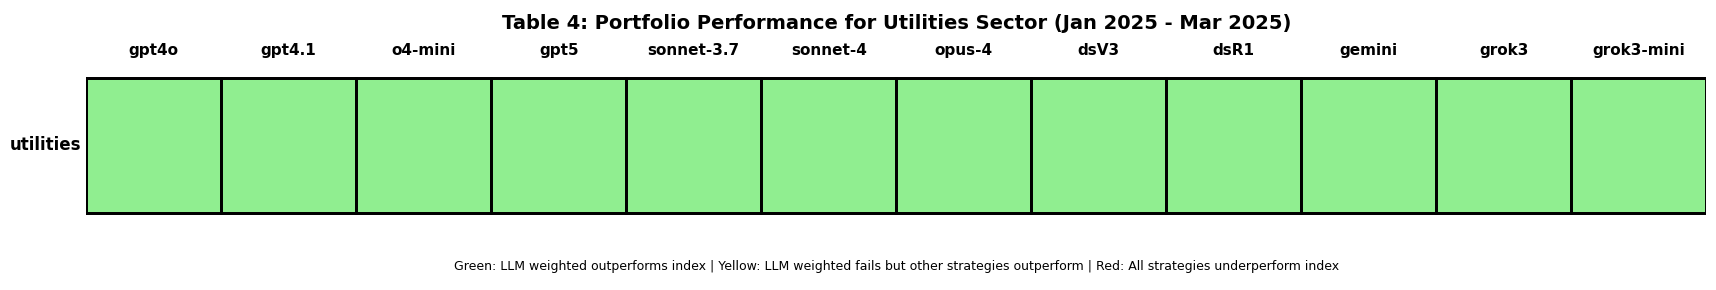

In [215]:
import matplotlib.patches as patches

data = cumulative_returns_diff_comp.mean()


models = []
for idx in data.index:
    model = idx.split('_')[0] 
    if ' ' in model:  
        model = idx.split(' ')[0]
    if model not in models:
        models.append(model)

colors = []

for model in models:
    weighted_value = None
    other_values = []
    
    for idx, value in data.items():
        if idx.startswith(model):
            if 'weighted' in idx:
                weighted_value = value
            else:
                other_values.append(value)
    
    if weighted_value is not None and weighted_value < 0:
        colors.append('#90EE90')
    elif weighted_value is not None and any(v < 0 for v in other_values):
        colors.append('#FFD700') 
    else:
        colors.append('#FFB6C1')

fig, ax = plt.subplots(figsize=(len(models)*1.5, 3))
ax.set_xlim(0, len(models))
ax.set_ylim(0, 2)
ax.set_aspect('equal')

for j, (model, color) in enumerate(zip(models, colors)):
    
    rect = patches.Rectangle((j, 0.5), 1, 1, 
                           linewidth=2, edgecolor='black', facecolor=color)
    ax.add_patch(rect)

for j, model in enumerate(models):
    ax.text(j+0.5, 1.7, model, ha='center', va='center', 
            fontweight='bold', fontsize=11)

ax.text(-0.3, 1, sector_name, ha='center', va='center', 
        fontweight='bold', fontsize=12)

ax.axhline(y=0.5, xmin=0, xmax=1, color='black', linewidth=2)
ax.axhline(y=1.5, xmin=0, xmax=1, color='black', linewidth=2)
for j in range(len(models) + 1):
    ax.axvline(x=j, ymin=0.5/2, ymax=1.5/2, color='black', linewidth=2)

ax.text(len(models)/2, 1.9, f'Table 4: Portfolio Performance for {sector_name_full} Sector (Jan 2025 - Mar 2025)', 
        ha='center', va='center', fontweight='bold', fontsize=14)

legend_text = ('Green: LLM weighted outperforms index | '
               'Yellow: LLM weighted fails but other strategies outperform | '
               'Red: All strategies underperform index')
ax.text(len(models)/2, 0.1, legend_text, ha='center', va='center', fontsize=9)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.tight_layout()
plt.show()

## Summary metrics preparation

In [216]:
sector_diff_summary = cumulative_returns_diff_comp.mean()

sector_results = pd.DataFrame({
    'sector': sector_name,
    'portfolio': sector_diff_summary.index,
    'difference': sector_diff_summary.values
})

csv_filename = 'difference/sector_performance_differences_stocks20_Jan.csv'

if os.path.exists(csv_filename):
    existing_data = pd.read_csv(csv_filename)
    if sector_name in existing_data['sector'].values:
        print(f"Updated data for sector: {sector_name}")
    else:
        print(f"Added new sector: {sector_name}")
    existing_data = existing_data[existing_data['sector'] != sector_name]
    combined_data = pd.concat([existing_data, sector_results], ignore_index=True)
    combined_data.to_csv(csv_filename, mode='w', header=True, index=False)
else:
    sector_results.to_csv(csv_filename, mode='w', header=True, index=False)
    print(f"Created new file with sector: {sector_name}")

print(f"Data has been saved to {csv_filename}")
print(f"Current sector: {sector_name}")
print(f"Saved {len(sector_results)} indicators")

Updated data for sector: utilities
Data has been saved to difference/sector_performance_differences_stocks20_Jan.csv
Current sector: utilities
Saved 60 indicators


## Volatilities

In [217]:
# for model_short in model_shorts:

#     sector_mean = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}'].mean()
#     sector_diff_sq = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}'].apply(lambda x: (x - sector_mean)**2)
#     sector_sumdiff = sector_diff_sq.sum() / cumulative_returns_compare.size
#     sector_volatility = round(sqrt(sector_sumdiff), 5)

#     print(sector_name, sector_volatility, model_short)
#     with open('metrics/portfolio_volatilities.csv', 'a', encoding='utf-8') as f:
#         f.write(f'{model_short},{sector_name},{sector_volatility}\n')

In [218]:
if not os.path.exists('metrics/portfolio_volatilities.csv'):
    pd.DataFrame(columns=['model', 'sector', 'time split', 'volatility']).to_csv('metrics/portfolio_volatilities.csv', index=False)

df = pd.read_csv('metrics/portfolio_volatilities.csv')

for model_short in model_shorts:
    sector_data = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}']
    sector_volatility = round(sector_data.std(), 5)

    print(sector_name, sector_volatility, model_short)

    condition = (df['model'] == model_short) & (df['sector'] == sector_name) & (df['time split'] == 'Jan')
    
    if condition.any():
        df.loc[condition, 'volatility'] = sector_volatility
    else:
        new_row = pd.DataFrame({
            'model': [model_short],
            'sector': [sector_name], 
            'time split': ['Jan'],
            'volatility': [sector_volatility]
        })
        df = pd.concat([df, new_row], ignore_index=True)

df.to_csv('metrics/portfolio_volatilities.csv', index=False)

utilities 0.0318 gpt4o
utilities 0.03259 gpt4.1
utilities 0.03442 o4-mini
utilities 0.02524 gpt5
utilities 0.02801 sonnet-3.7
utilities 0.02531 sonnet-4
utilities 0.02335 opus-4
utilities 0.03149 dsV3
utilities 0.0302 dsR1
utilities 0.02387 gemini
utilities 0.03527 grok3
utilities 0.03143 grok3-mini


## Sector Index Volatility (not finished)

In [219]:
# globals()[f'insample_stock_returns_{sector_name}'] = df_returns[globals()[f'stocks_{sector_name}']]
# temp_stock_return_insample = globals()[f'insample_stock_returns_{sector_name}']
# cumulative_returns_gpt_insample = pd.DataFrame(index=temp_stock_return_insample.index)
# cumulative_returns_gpt_insample

# i = 0
# for name, weight in weights.items():
#     temp_stock_return = globals()[f'insample_stock_returns_{sector_name}']
#     portfolio_return = (temp_stock_return * weight).sum(axis=1)
#     cumulative_returns_gpt_insample[name] = (1 + portfolio_return).cumprod()
#     i+=1

# print(cumulative_returns_gpt_insample.columns)

# cumulative_returns_gpt_insample[index_names[sector_ticker]] = (1 + index_data_ins[ticker]).cumprod()

# cumulative_returns_gpt_insample.index = pd.to_datetime(cumulative_returns_gpt_insample.index)
# insample_data = cumulative_returns_gpt_insample.loc[insample_startdate:insample_enddate]


# insample_data

## Portfolio Performance

Plot with Scrollable Legend (Display Only)

In [220]:
temp_index_data_outs_compare = index_data_outs.copy()

temp_index_data_outs_compare.index = pd.to_datetime(temp_index_data_outs_compare.index)

index_first_date_compare = temp_index_data_outs_compare.index[0]
index_previous_trading_date_compare = index_first_date_compare - BDay(1)

index_baseline_row_compare = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs_compare.shape[1])),  
    index=[index_previous_trading_date_compare],                 
    columns=temp_index_data_outs_compare.columns               
)

temp_index_data_outs_compare_with_baseline = pd.concat([index_baseline_row_compare, temp_index_data_outs_compare])
# ##above is to add a baseline row with zeros to the index data outs compare dataframe##

index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

cumulative_returns_compare[index_names[sector_ticker]] = (1 + index_data_outs[ticker]).cumprod()

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)
outsample_data = cumulative_returns_compare.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for i, column in enumerate(outsample_data.columns):
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))

    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Jan 1 to Mar 31, 2025', 
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified",
    height=600,
    plot_bgcolor='white',
    xaxis=dict(
        gridcolor='lightgray',          
        linecolor='black',
        linewidth=1.5
    ),
    yaxis=dict(
        gridcolor='lightgray',     
        linecolor='black', 
        linewidth=1.5
    )
)

fig.update_layout(legend=dict(orientation = "v", yanchor="top",y=1,xanchor="left", x=1.02))


fig.show()


Plot with Multi-Column Legend (For Download/Export)

In [221]:
temp_index_data_outs_compare = index_data_outs.copy()

temp_index_data_outs_compare.index = pd.to_datetime(temp_index_data_outs_compare.index)

index_first_date_compare = temp_index_data_outs_compare.index[0]
index_previous_trading_date_compare = index_first_date_compare - BDay(1)

index_baseline_row_compare = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs_compare.shape[1])),  
    index=[index_previous_trading_date_compare],                 
    columns=temp_index_data_outs_compare.columns               
)

temp_index_data_outs_compare_with_baseline = pd.concat([index_baseline_row_compare, temp_index_data_outs_compare])
# ##above is to add a baseline row with zeros to the index data outs compare dataframe##

index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_compare_with_baseline[ticker]).cumprod() ##

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)
outsample_data = cumulative_returns_compare.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for i, column in enumerate(outsample_data.columns):
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))

    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Jan 1 to Mar 31, 2025', 
    title_x = 0.5,
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified",
    width=1400,        
    height=800,
    margin=dict(b=150), 
    plot_bgcolor='white',
    xaxis=dict(
        gridcolor='lightgray',          
        linecolor='black',
        linewidth=1.5
    ),
    yaxis=dict(
        gridcolor='lightgray',     
        linecolor='black', 
        linewidth=1.5
    )
)

# fig.update_layout(legend=dict(orientation = "v", yanchor="top",y=1,xanchor="left", x=1.02))
fig.update_layout(legend=dict(
        orientation="h", 
        yanchor="top",
        y=-0.15,  
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ))

fig.show()


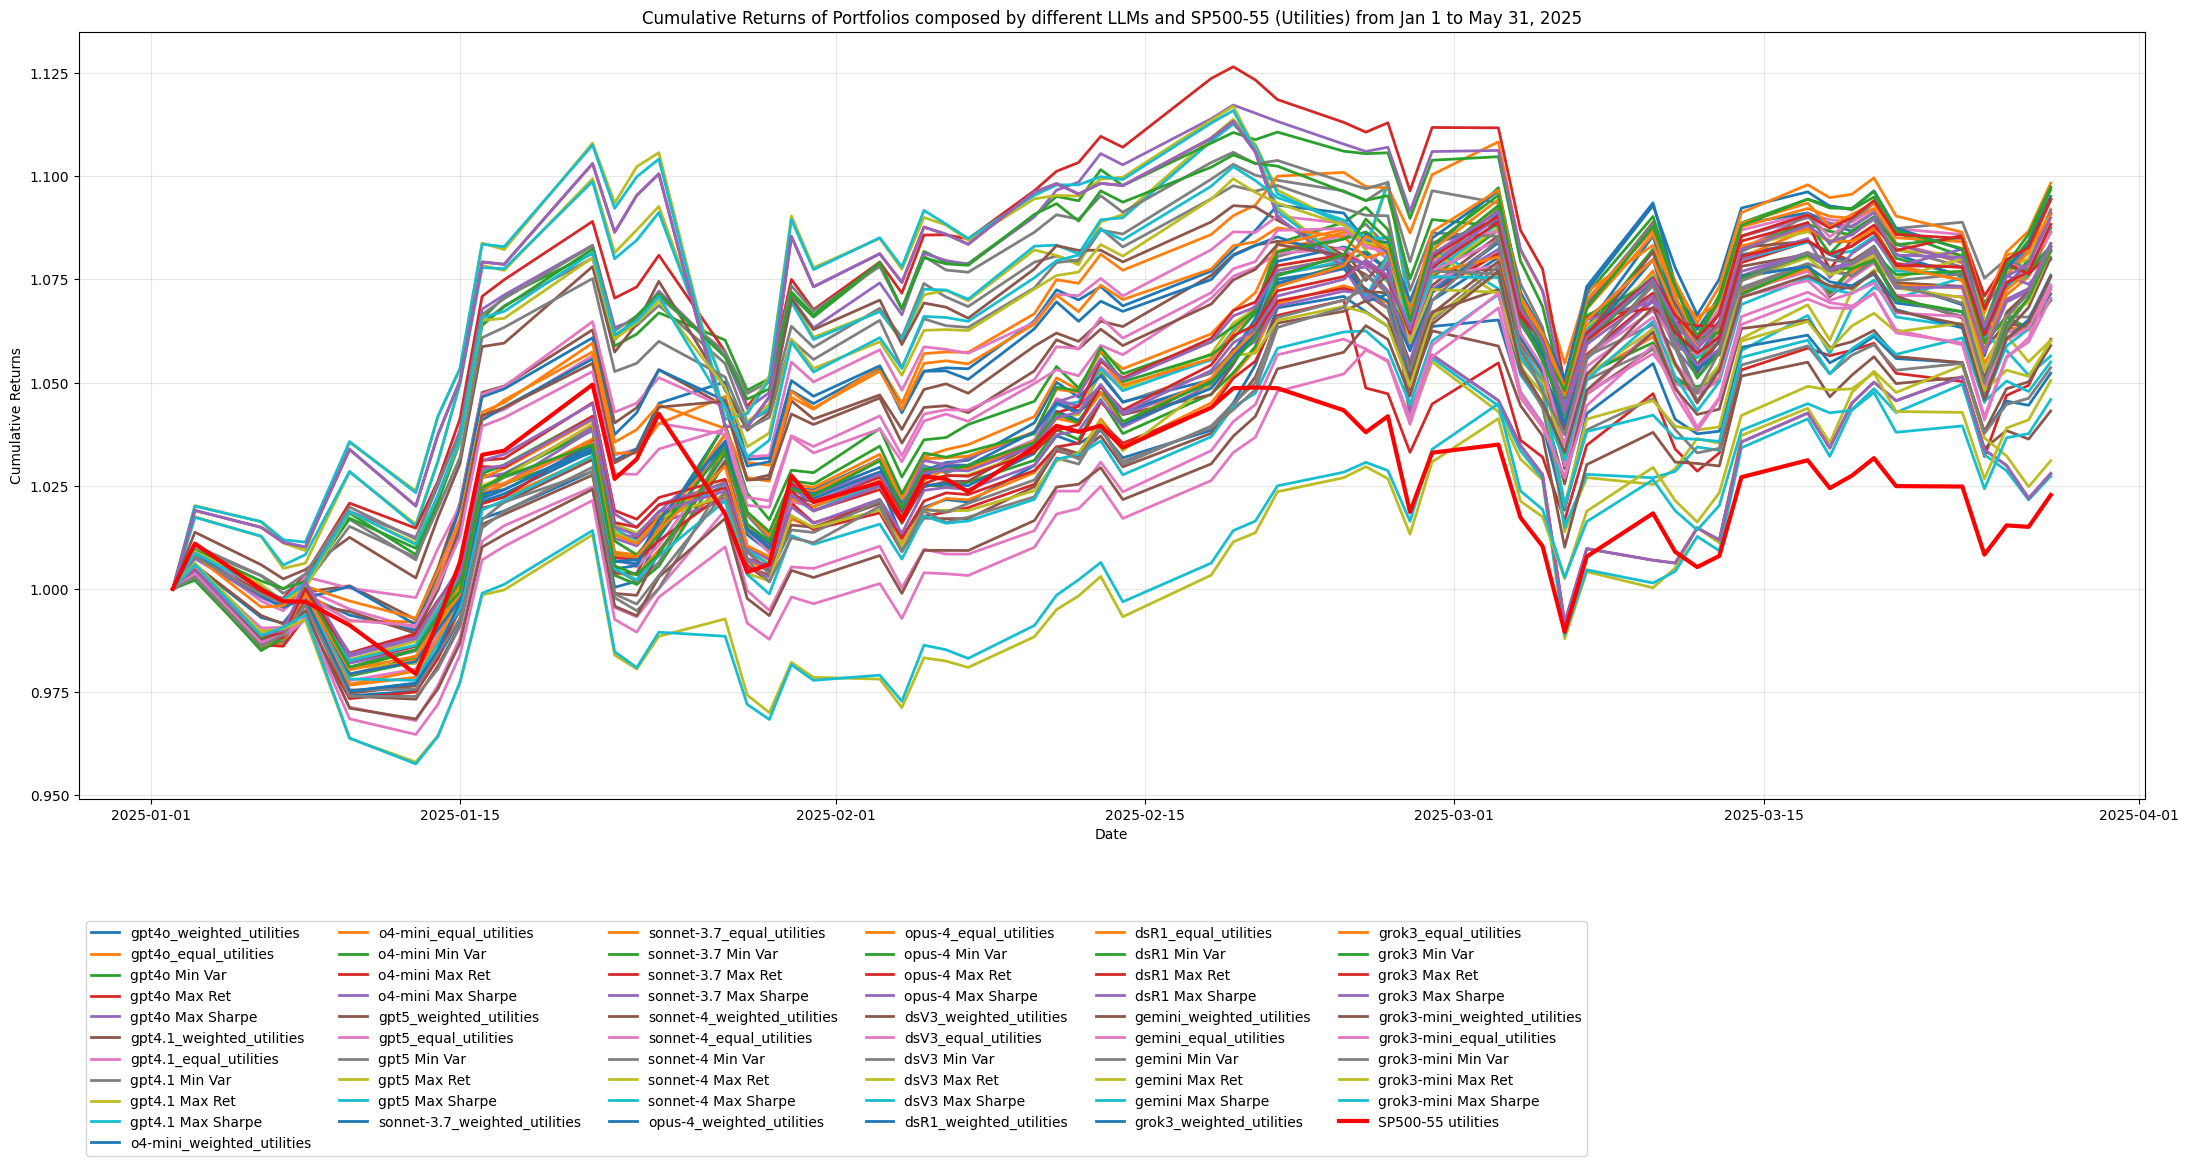

: 

In [ ]:
fig, ax = plt.subplots(figsize=(22,12))

for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        ax.plot(outsample_data.index, outsample_data[column], 
               linewidth=3, color='red', label=column)
    else:
        ax.plot(outsample_data.index, outsample_data[column], 
               linewidth=2, label=column)

ax.set_title(f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Jan 1 to May 31, 2025')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax.legend(bbox_to_anchor=(0, -0.15), loc='upper left', ncol=6)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()